In [1]:
!pip install yfinance
!pip install --upgrade keras

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [2]:
# Get stock data (e.g., Apple)
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2023-12-31')
print(data.head())


/tmp/ipython-input-2-2918692036.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.288584  24.757338  23.848709  24.746230  212818400
2015-01-05  23.604340  24.137520  23.417727  24.057543  257142000
2015-01-06  23.606554  23.866479  23.244435  23.668758  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857306  24.915067  24.148620  24.266365  237458000


In [3]:
# Use only the 'Close' price
close_data = data[['Close']].values

# Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

# Create sequences for LSTM
X, y = [], []
sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Reshape input for LSTM: [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [4]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0563
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 5.9969e-04
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.1517e-04
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 5.7781e-04
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.6342e-04
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5.4567e-04
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 4.9361e-04
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.7847e-04
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 4.3966e-04
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.6145e-04


In [6]:
# Prepare test data (last 60 days of training data)
test_input = scaled_data[-sequence_length:]
test_input = np.reshape(test_input, (1, test_input.shape[0], 1))

# Predict the next day
predicted_price = model.predict(test_input)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted next day's price for {ticker}: ${predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Predicted next day's price for AAPL: $193.25


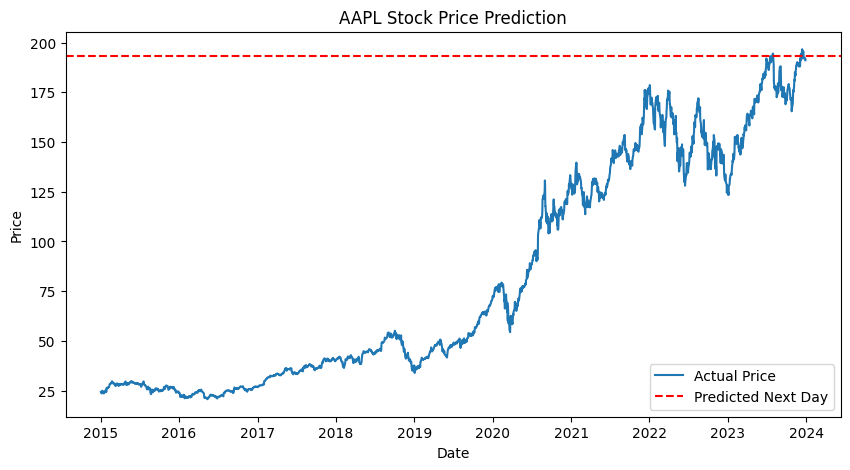

In [7]:
# Plot actual vs predicted price
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Actual Price')
plt.axhline(y=predicted_price[0][0], color='r', linestyle='--', label='Predicted Next Day')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [8]:
model.save("stock_lstm_model.h5")


In [9]:
from google.colab import files
files.download("stock_lstm_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
print(f"Predicted next day's price for {ticker}: ${predicted_price[0][0]:.2f}")


Predicted next day's price for AAPL: $193.25


In [11]:
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]


In [12]:
for _ in range(7):
    next_input = ...


In [14]:
# Prepare data for output file
predicted_price_value = predicted_price[0][0]
last_date = data.index[-1]  # last date in dataset
output_df = pd.DataFrame({
    'Date': [last_date + pd.Timedelta(days=1)],
    'Predicted_Close_Price': [predicted_price_value]
})

# Save as CSV
output_df.to_csv('predicted_price.csv', index=False)

# Download file in Colab
from google.colab import files
files.download('predicted_price.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Predict stock prices for the next 7 days
future_days = 7
last_60_days = scaled_data[-60:]
predicted_prices = []

for i in range(future_days):
    input_data = last_60_days[-60:]  # always last 60 points
    input_data = np.reshape(input_data, (1, input_data.shape[0], 1))

    next_pred = model.predict(input_data)[0][0]
    predicted_prices.append(next_pred)

    # Append this prediction to the last_60_days for next iteration
    last_60_days = np.append(last_60_days, [[next_pred]], axis=0)

# Inverse transform to original price scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# Prepare date range for next 7 days
last_date = data.index[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(future_days)]

# Save to DataFrame
output_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price': predicted_prices
})

print(output_df)

# Save CSV
output_df.to_csv('predicted_7_days.csv', index=False)

# Download in Colab
from google.colab import files
files.download('predicted_7_days.csv')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
        Date  Predicted_Close_Price
0 2023-12-30             193.247406
1 2023-12-31             193.013733
2 2024-01-01             192.854645
3 2024-01-02             192.748245
4 2024-01-03             192.678970
5 2024-01-04             192.635437
6 2024-01-05             192.609589


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Predict stock prices for next 1 year (approx. 252 trading days)
future_days = 252
last_60_days = scaled_data[-60:]
predicted_prices = []

for i in range(future_days):
    input_data = last_60_days[-60:]  # last 60 data points
    input_data = np.reshape(input_data, (1, input_data.shape[0], 1))

    next_pred = model.predict(input_data)[0][0]
    predicted_prices.append(next_pred)

    # Add prediction to the input window
    last_60_days = np.append(last_60_days, [[next_pred]], axis=0)

# Convert predicted prices back to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# Generate future dates (weekdays only, since market is closed on weekends)
from pandas.tseries.offsets import BDay

last_date = data.index[-1]
future_dates = [last_date + BDay(i + 1) for i in range(future_days)]

# Save to DataFrame
output_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price': predicted_prices
})

# Print first few rows
print(output_df.head())


output_df.to_csv('predicted_1_year.csv', index=False)


from google.colab import files
files.download('predicted_1_year.csv')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

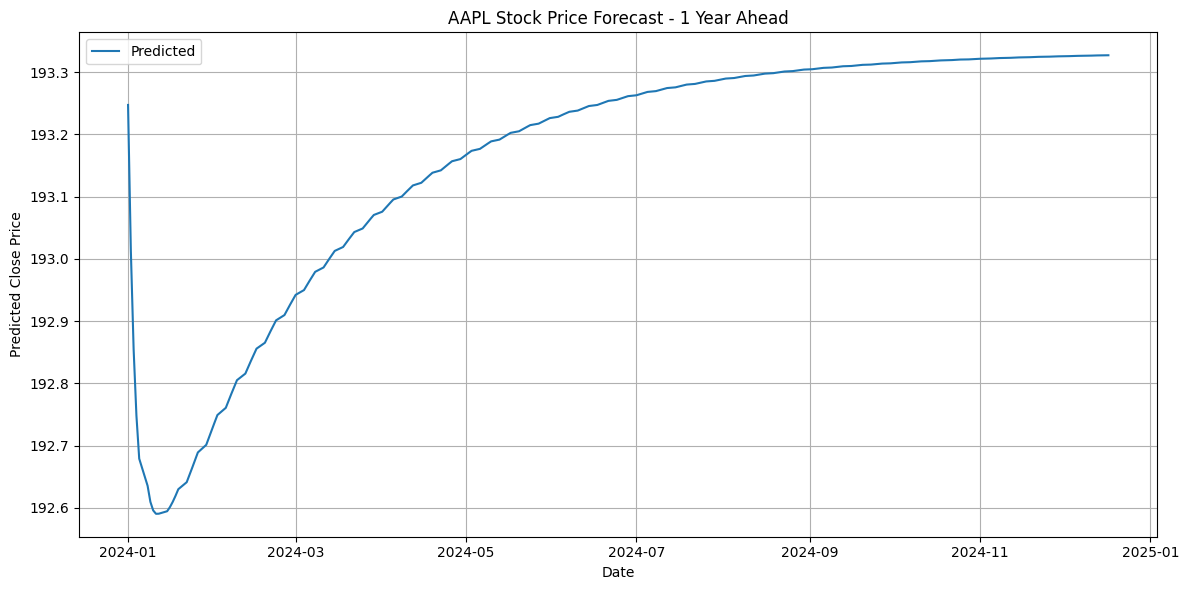

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(output_df['Date'], output_df['Predicted_Close_Price'], label='Predicted')
plt.title(f"{ticker} Stock Price Forecast - 1 Year Ahead")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("predicted_1_year_plot.png")
files.download("predicted_1_year_plot.png")
plt.show()
